Demonstrates testing equality of samples from two models of viral infection with the same mean and standard deviation. 

Requires antimony, matplotlib, roadrunner

In [1]:
import antimony
from matplotlib import pyplot as plt
import numpy as np
from roadrunner import RoadRunner

import sbsr

In [2]:
def antimony_to_sbml(model_string: str) -> str:
    antimony.clearPreviousLoads()
    antimony.loadAntimonyString(model_string)
    module_name = antimony.getMainModuleName()
    return antimony.getSBMLString(module_name)


v_mean = 100.0
v_stdev = 20.0
model_names = ['S', 'I', 'R', 'V']
time_final = 10.0
num_steps = 100

model_1 = f"""
species S, I, R, V;

S -> I ; beta * S * V;
I -> R ; delta * I;
-> V  ; p * I - k * V;

S = 1E6;
I = 0.0;
R = 0.0;
V = normal({v_mean}, {v_stdev}, 0, {v_mean * 1E6});

beta = 2.0E-6;
k = 4.0;
delta = 1E0;
p = 25.0;
"""

model_2 = f"""
species S, I, R, V;

S -> I ; beta * S * V;
I -> R ; delta * I;
-> V  ; p * I - k * V;

S = 1E6;
I = 0.0;
R = 0.0;
V = uniform({v_mean - v_stdev * np.sqrt(3)}, {v_mean + v_stdev * np.sqrt(3)});

beta = 2.0E-6;
k = 4.0;
delta = 1E0;
p = 25.0;
"""

rr_1 = RoadRunner(antimony_to_sbml(model_1))
rr_2 = RoadRunner(antimony_to_sbml(model_2))


In [3]:
sample_size = 10000

results_all = []
rr_all = [rr_1, rr_2, rr_1]
dist_labels = ['Normal', 'Uniform', 'Normal']

results_times = None

for j in range(len(rr_all)):
    rr = rr_all[j]
    
    res_j = {name: np.ndarray((sample_size, num_steps), dtype=float) for name in model_names}
    
    for i in range(sample_size):
        rr.resetAll()
        rr_res = rr.simulate(0.0, time_final, num_steps)
        if results_times is None:
            results_times = rr_res['time']
        for name in model_names:
            res_j[name][i, :] = rr_res[f'[{name}]']
    
    results_all.append(res_j)

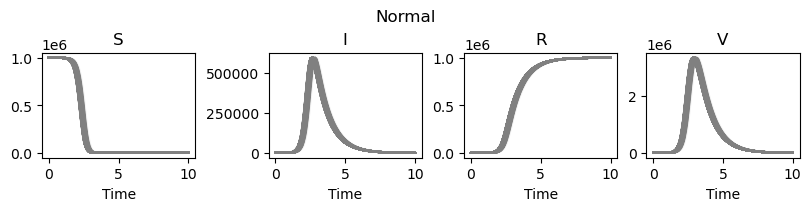

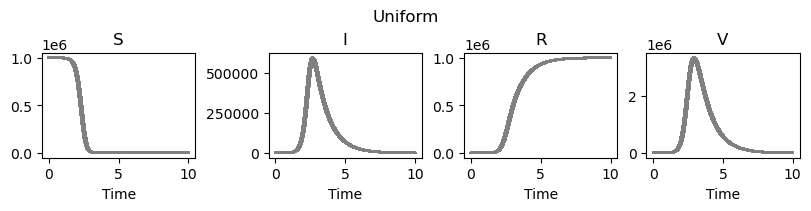

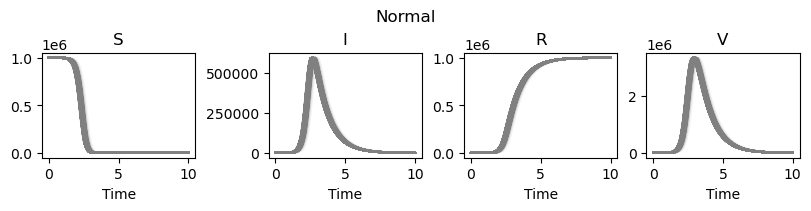

In [4]:
for k in range(len(results_all)):
    fig, ax = plt.subplots(1, len(model_names), figsize=(8.0, 2.0), layout='compressed')
    for i, n in enumerate(model_names):
        for j in range(sample_size):
            ax[i].plot(results_times, results_all[k][n][j, :], alpha=0.1, color='gray')
        ax[i].set_title(n)
        ax[i].set_xlabel('Time')
    fig.suptitle(dist_labels[k])

In [5]:
stats_all = []

for j in range(len(results_all)):
    stats_j = {n: np.zeros((len(results_times), 2), dtype=float) for n in model_names}
    for n in model_names:
        stats_j[n].T[:] = np.mean(results_all[j][n], 0), np.std(results_all[j][n], 0)
    stats_all.append(stats_j)

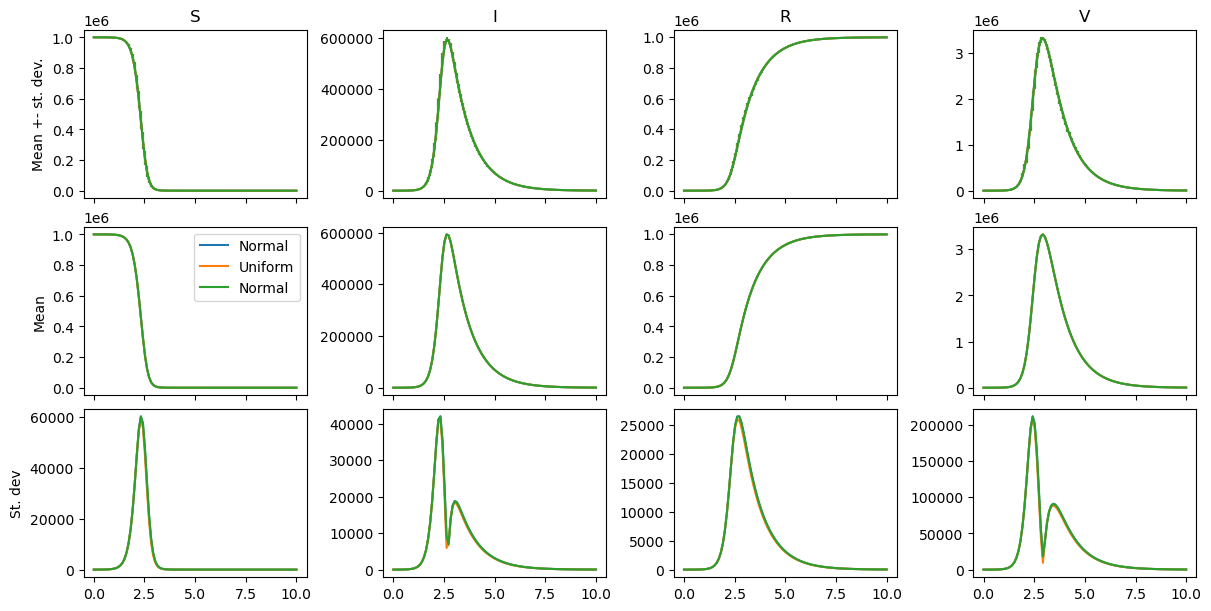

In [6]:
fig, ax = plt.subplots(3, len(model_names), figsize=(12.0, 6.0), layout='compressed', sharex=True)
for i, name in enumerate(model_names):
    for j, stats in enumerate(stats_all):
        ax[0][i].errorbar(results_times, stats[name][:, 0], yerr=stats[name][:, 1], label=dist_labels[j])
        ax[1][i].plot(results_times, stats[name][:, 0], label=dist_labels[j])
        ax[2][i].plot(results_times, stats[name][:, 1], label=dist_labels[j])
    
    ax[0][i].set_title(name)
ax[0][0].set_ylabel('Mean +- st. dev.')
ax[1][0].set_ylabel('Mean')
ax[2][0].set_ylabel('St. dev')
ax[1][0].legend(dist_labels)

In [7]:
num_evals = 100
num_pers = 5

ecf_all = []
eval_t_all = {n: [0.0] * num_steps for n in model_names}

for name in model_names:
    for i in range(num_steps):
        eval_t_all[name][i] = sbsr.get_eval_info_times(num_evals, sbsr.eval_final(results_all[0][n][:, i].T[:], num_pers))

for j in range(len(results_all)):
    ecf_j = {}
    for name in model_names:
        ecf_n = np.ndarray((num_steps, num_evals, 2), dtype=float)
        for i in range(num_steps):
            ecf_n[i, :, :] = sbsr.ecf(results_all[j][n][:, i].T, eval_t_all[name][i]).copy()
        ecf_j[name] = ecf_n.copy()
    ecf_all.append(ecf_j)

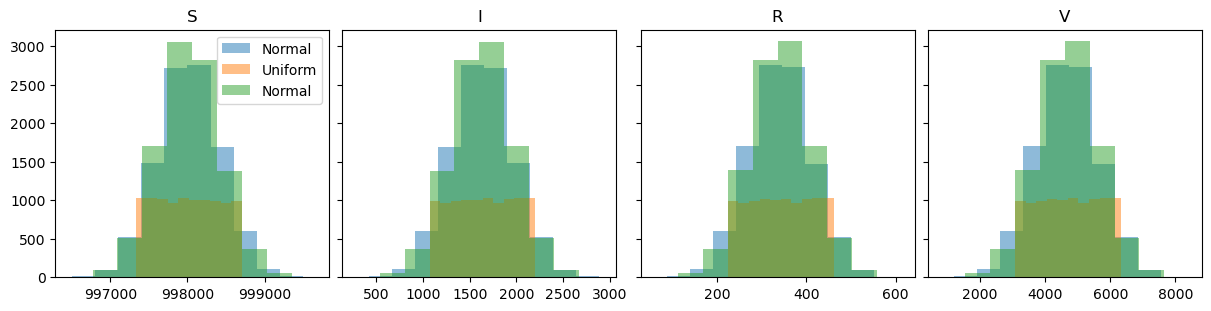

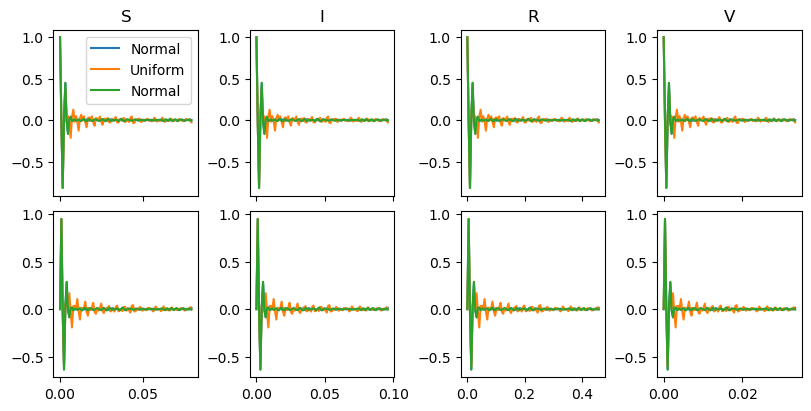

In [8]:
step_oi = 10

fig, ax = plt.subplots(1, len(model_names), figsize=(12.0, 3.0), layout='compressed', sharey=True)
for i, name in enumerate(model_names):
    for res in results_all:
        ax[i].hist(res[name][:, step_oi], alpha=0.5)
    ax[i].set_title(name)
ax[0].legend(dist_labels)

fig, ax = plt.subplots(2, len(model_names), figsize=(8.0, 4.0), layout='compressed', sharex='col')
for i, name in enumerate(model_names):
    eval_t = sbsr.get_eval_info_times(num_evals, sbsr.eval_final(results_all[0][name].T[step_oi, :], num_pers))
    
    for j, ecf_j in enumerate(ecf_all):
        ax[0][i].plot(eval_t, ecf_j[name][step_oi, :, 0], label=dist_labels[j])
        ax[1][i].plot(eval_t, ecf_j[name][step_oi, :, 1], label=dist_labels[j])
    
    ax[0][i].set_title(name)
ax[0][0].legend(dist_labels)

In [9]:
ecf_diff = []
err_max_idx = 0
err_max_val = 0
for j, ecf_j in enumerate(ecf_all[1:]):
    ecf_diff_j = {}
    for name in model_names:
        ecf_diff_name = 0.0
        for i in range(num_steps):
            err_ij = sbsr.ecf_compare(ecf_all[0][name][i, :], ecf_j[name][i, :])
            ecf_diff_name = max(ecf_diff_name, err_ij)
            if j == 1 and err_ij > err_max_val:
                err_max_val = err_ij
                err_max_idx = i
        ecf_diff_j[name] = ecf_diff_name
    ecf_diff.append(ecf_diff_j.copy())

print(f'Maximum error compared to Normal sample occurred at simulation time {results_times[err_max_idx]}')
for j in range(len(ecf_diff)):
    print(f'{dist_labels[j+1]} error: {max(ecf_diff[j].values())} ({ecf_diff[j]})')

Maximum error compared to Normal sample occurred at simulation time 2.727272727272727
Uniform error: 0.25647642276951876 ({'S': 0.25647642276951876, 'I': 0.25647642276951876, 'R': 0.25647642276951876, 'V': 0.25647642276951876})
Normal error: 0.03361796395577594 ({'S': 0.03361796395577594, 'I': 0.03361796395577594, 'R': 0.03361796395577594, 'V': 0.03361796395577594})


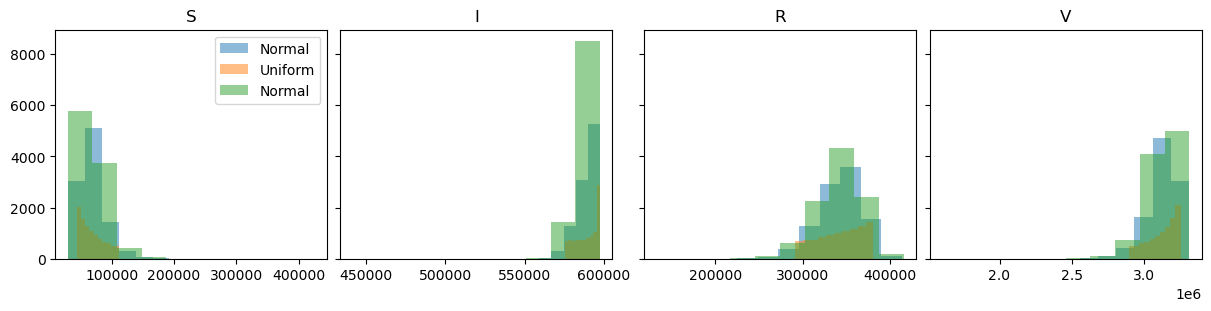

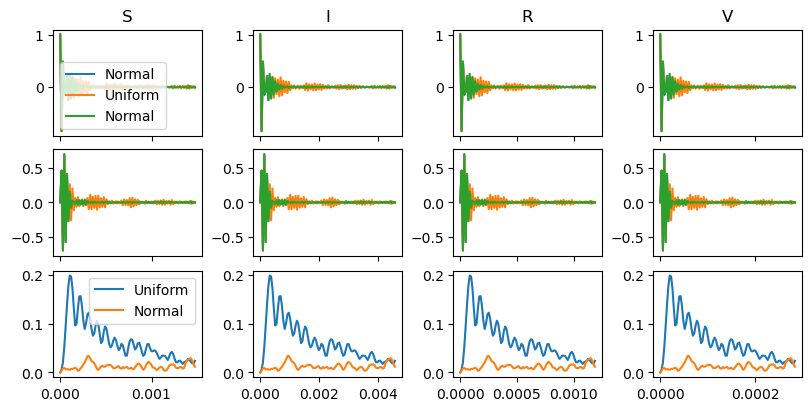

In [10]:
fig, ax = plt.subplots(1, len(model_names), figsize=(12.0, 3.0), layout='compressed', sharey=True)
for i, name in enumerate(model_names):
    for res in results_all:
        ax[i].hist(res[name][:, err_max_idx], alpha=0.5)
    ax[i].set_title(name)
ax[0].legend(dist_labels)

fig, ax = plt.subplots(3, len(model_names), figsize=(8.0, 4.0), layout='compressed', sharex='col')
for i, name in enumerate(model_names):
    eval_t = sbsr.get_eval_info_times(num_evals, sbsr.eval_final(results_all[0][name][:, err_max_idx].T, num_pers))
    
    for j, ecf_j in enumerate(ecf_all):
        ax[0][i].plot(eval_t, ecf_j[name][err_max_idx, :, 0], label=dist_labels[j])
        ax[1][i].plot(eval_t, ecf_j[name][err_max_idx, :, 1], label=dist_labels[j])
        
        if j > 0:
            err = np.sqrt(np.square(ecf_j[name][err_max_idx, :, 0] - ecf_all[0][name][err_max_idx, :, 0]) + np.square(ecf_j[name][err_max_idx, :, 1] - ecf_all[0][name][err_max_idx, :, 1]))
            ax[2][i].plot(eval_t, err, label=dist_labels[j])
    
    ax[0][i].set_title(name)
ax[0][0].legend(dist_labels)
ax[2][0].legend(dist_labels[1:])